<a href="https://colab.research.google.com/github/bless-god/MODS203/blob/main/invest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Backgroud**

There is a portfolio $Pf$ invested into funds $\{f_1, f_2, \cdots, f_n\}$, with weights on each ticker $\{cw_1, cw_2,\cdots, cw_n\}$. According to some theory, the ideal weight $\{mw_1,mw_2,\cdots,mw_n\}$ will yield the maximum profit.

Now we invest amount $A$ into portfolio $Pf$, and the goal is to spread $A$ across funds $\{f_1, f_2, \cdots, f_n\}$ which makes the updated portfolio $\{nw_1, nw_2, \cdots, nw_n\}$ getting as close to model weight as possible.


## **Problem setup**

Define the current weight under the primary portfolio: $$CW = \{cw_1, cw_2,\cdots, cw_n\}$$, and the ideal model weight is $$MW = \{mw_1,mw_2,\cdots,mw_n\}$$

​After investing $A$, the total funding rises to $Pf+A$, the primary portfolio only counts a proportion of overall funding $\frac{Pf}{Pf+A}$, so the weight is normalized $$CW_{normalized}=\{\frac{cw_1*Pf}{Pf+A}, \frac{cw_2*Pf}{Pf+A},\cdots, \frac{cw_n*Pf}{Pf+A}\}$$


<!-- Ideal weight deduced by economic theory which indicates weight for maximum profit

Topup=10; Fund=90; totalfunding=100, change of weight=10%; 

10 tickers: {1%, 1%, .., 1%} -->

​Change of weight on each ticker due to top up is $\Delta CW = \{\Delta cw_1,\Delta cw_2, \cdots,\Delta cw_n\}$

While $\Sigma (\Delta cw_i) = \frac{A}{Pf+A}$ and $\Delta cw_i \ge 0$.

## **Formulation**

​	The objective function describes the distance between the weight on tickers after top up and the model weight: 
$$f(\Delta CW)=\|MW-(CW_{normalized}+\Delta CW)\|^2$$

Objective function for relative distance:
$$\begin{aligned}
f_2(\Delta CW)&=\log[(MW-(CW_{normalized}+\Delta CW))/MW]^2\\
&=2\Sigma_{i=1}^n [\log(MW_i-CW_{normalized}i-\Delta CW_i)-log(MW_i)]
\end{aligned}$$


$$\begin{aligned}
f_3(\Delta CW)&=\|(CW_{normalized}+\Delta CW-MW))/MW\|^2\\
&=\Sigma_{i=1}^n [(cw_{normalized}i+\Delta cw_i-mw_i)/mw_i]^2\\
&=\Sigma_{i=1}^n [\frac{fw_i-mw_i}{mw_i}] ^2
\end{aligned}$$
where $mw_i\neq 0$.

<!-- $$d f_2(CW_i)=\frac{1}{CW_i+dw_i-MW_i}$$ -->
​	The goal is to minimize the objective function
​				$$\mathop{\min}_{\Delta CW} f_2(\Delta CW)$$
$$s.t. \Sigma (\Delta cw_i) = \frac{A}{Pf+A}$$

$$\Delta cw_i \ge 0, i\in\{1,\cdots,n\}$$

## **Improvement**
In reality, the investment on every fund has a minimum entry criteria. Which means if you want to invest on one fund, you are supposed to put at least a certain amount of money on it, otherwise you can't top up on it. This property changes the second constraint to
$$\Delta cw_i=0\ or\ \Delta cw_i\ge b_i, i\in\{0,\cdots,n\}$$

Note here $b_i$ is not the minimum topup amount, it corresponds to the weight of the min topup. Mathematically, it's a linear programming problem with disjunctive constraints. The acadamic way to solve this was included in $\textit{Disjunctive programming: Properties of the convex hull of feasible points}$, which was quite complicated. And there is also a library ```pyomo``` able to solve disjunctive programming. Since the library is quite new and full of implementation bugs.

While in practice, the problem is solved by avoding the disjunctive constraints (just taking the constraints in **formulation** part), and manually selecting $\Delta cw_i$ to be $0$ or greater than $b_i$ depending on its distance with $b_i$. In each step of the optimization, we will have an output $\Delta CW$, and some $\Delta cw_i$ may value between $(0,b_i)$. the modified $\Delta CW^*$For these entities, we put it into the function:

<!-- $$\Delta cw_i^*=\lceil \Delta cw_i -\frac{b_i}{2}\rceil * b_i$$ -->

​		$$\Delta cw_i^* = \left\{\begin{aligned}0,&\ \ if\ \Delta cw_i < \frac{b_i}{2}\\ b_i,&\ if \ \frac{b_i}{2}\le\Delta cw_i < b_i\end{aligned}\right.$$


​	And the inequality constraints can be solved with the penalty term

<!-- ​		$$\iota_B(x)=\left\{\begin{aligned}0,\ \ if\ x\in B\\+\infty, if \ x\in B^C\end{aligned}\right.$$ -->

​	According to the context, the problem can be reformulated as

​	$$\mathop{\min}_{\Delta CW} \|MW-(CW_P+\Delta CW)\|+\Sigma_{i=1}^{n}\iota_B(\Delta CW_i)$$

​	while $B=(0,5)$



$x\ge b$

$b\in(0,1)$


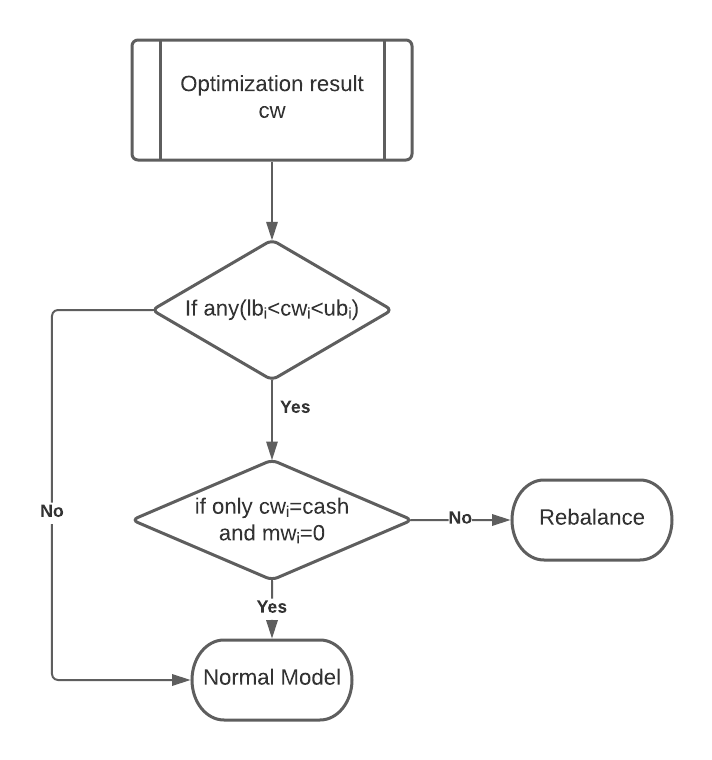

In [1]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import copy

In [2]:
#@title
class stock:
  def __init__(self):
    self.ticker = None
    self.marketprice = None;
    self.value = None;
    self.units = None;
    self.minInitialInvestmentAmt = None;
    self.minTopupAmt = None;
    self.minTopupUnits = None;
    self.weight = None;
    self.contributionFee = None;
    self.minRedemptionAmt = None;
    self.minRedemptionUnits = None;

class portfolio:
  def __init__(self):
    self.ticker = None;
    self.weight = None; # model weight: important
    self.marketprice = None;
    self.minInitialInvestmentAmt = None;

def readStock(ticker):
  tc = stock()
  tc.ticker = ticker['ticker']
  tc.marketprice = float(ticker['marketPrice'])
  tc.units = ticker['units']
  tc.value = float(ticker['value'])
  tc.minTopupUnits = float(ticker['minTopupUnits'])
  tc.minTopupAmt = float(ticker['minTopupAmt'])
  tc.minInitialInvestmentAmt = float(ticker['minInitialInvestmentAmt'])
  tc.contributionFee = float(ticker['contributionFee'])
  tc.minRedemptionAmt = float(ticker['minRedemptionAmt'])
  tc.minRedemptionUnits = float(ticker['minRedemptionUnits'])
  tc.minHoldingAmt = float(ticker['minHoldingAmt'])
  return tc

def readPortfolio(ptfl):
  pf = portfolio()
  pf.ticker = ptfl['ticker']
  pf.marketprice = ptfl['marketPrice']
  pf.weight = ptfl['weight']
  pf.minInitialInvestmentAmt = ptfl['minInitialInvestmentAmt']
  pf.minHoldingAmt = ptfl['minHoldingAmt']

  return pf

def readPtfls(ptfls):
  pt = []
  for i in ptfls:
    pt.append(readPortfolio(i))
  return pt

def readDetail(details):
  tickers = []
  for i in details:
    tickers.append(readStock(i))
  return tickers

def complete(tcs, pfs):
  for j in pfs:
    for i in range(0, len(tcs)):
      if tcs[i].ticker == j.ticker:
        tcs[i].weight = j.weight
  return tcs

In [3]:
input = {
  "amountDecimalPrecision": "2",
  "unitDecimalPrecision": "5",
  "volatilityBuffer": "0.1",
  "goals": [
    {
      "goalId": "123",
      "goalDetails": [
        {
          "ticker": "VTI",
          "units": "5.01636",
          "marketPrice": "141.81",
          "value": "711.37",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "DGRO",
          "units": "17.24309",
          "marketPrice": "35.36",
          "value": "609.72",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "IWP",
          "units": "0.49134",
          "marketPrice": "136.75",
          "value": "67.19",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "VWO",
          "units": "1.92159",
          "marketPrice": "34.96",
          "value": "67.18",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "IVW",
          "units": "0.36160",
          "marketPrice": "183.70",
          "value": "66.43",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "EFAV",
          "units": "4.45741",
          "marketPrice": "63.51",
          "value": "283.09",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "AGG",
          "units": "2.535",
          "marketPrice": "116.87",
          "value": "296.27",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "MUB",
          "units": "5.04488",
          "marketPrice": "111.57",
          "value": "562.86",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "PNQI",
          "units": "0.00041",
          "marketPrice": "142.05",
          "value": "0.06",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "CASH",
          "units": "75",
          "marketPrice": "1",
          "value": "0",
          "minInitialInvestmentAmt": "0.01",
          "minInitialInvestmentUnits": "0.01",
          "minTopupAmt": "0.01",
          "minTopupUnits": "0.01",
          "minRedemptionAmt": "0.01",
          "minRedemptionUnits": "0.01",
          "minHoldingAmt": "0.01",
          "minHoldingUnits": "0.01",
          "contributionFee": "0"
        }
      ],
      "orderAmount": "100",
      "orderType": "Investment",
      "modelPortfolioId": "MP1",
      "modelPortfolioDetails": [
        {
          "ticker": "VTI",
          "weight": "0.26",
          "marketPrice": "141.81",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "DGRO",
          "weight": "0.22",
          "marketPrice": "35.36",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "IWP",
          "weight": "0.03",
          "marketPrice": "136.75",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "VWO",
          "weight": "0.03",
          "marketPrice": "34.96",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "IVW",
          "weight": "0.02",
          "marketPrice": "183.70",
          "value": "66.43",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "EFAV",
          "weight": "0.1",
          "marketPrice": "63.51",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "AGG",
          "weight": "0.11",
          "marketPrice": "116.87",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "MUB",
          "weight": "0.19",
          "marketPrice": "111.57",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "PNQI",
          "weight": "0.02",
          "marketPrice": "142.05",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "CASH",
          "weight": "0.02",
          "marketPrice": "1",
          "minInitialInvestmentAmt": "0.01",
          "minInitialInvestmentUnits": "0.01",
          "minTopupAmt": "0.01",
          "minTopupUnits": "0.01",
          "minRedemptionAmt": "0.01",
          "minRedemptionUnits": "0.01",
          "minHoldingAmt": "0.01",
          "minHoldingUnits": "0.01",
          "contributionFee": "0"
        }
      ]
    }
  ]
}

In [4]:
#@title
def relative_loss(mw, rw):
  # calculate the relative distance between model weight and real weight

  # ignore the 0 mw term
  # rw = [i + 1e-200 for i in rw]
  # mw = [i + 1e-200 for i in mw]
  ind = np.nonzero(mw)
  mw_nonzero = np.array([mw[i] for i in ind[0]])
  rw_nonzero = np.array([rw[i] for i in ind[0]])
  tmp = (rw_nonzero - mw_nonzero) / mw_nonzero
  # log_tmp = [np.log10(i)**2 for i in tmp if i < 100 and i > 0 ] #* np.array(np.not_equal(mw, rw)) 
  return np.linalg.norm(tmp)**2 

def to_set(x):
  """Convert input int, string, list, tuple, set -> set"""
  if type(x) == set:
    return x
  elif type(x) in [list, set]:
    return set(x)
  elif type(x) in [str, int]:
    return set([x])
  else:
    raise Exception("Unrecognized type.")

def decompose(amt_set, i, thres=0):
  for ind, val in enumerate(list(amt_set)):
    if to_set(i - val).issubset(amt_set) and i - val > thres:
      return val, i-val
      # break

In [5]:
details = input["goals"][0]['goalDetails']
ptfls = input["goals"][0]['modelPortfolioDetails']
orderAmt = float(input["goals"][0]['orderAmount'])

tcs = readDetail(details)
pfs = readPtfls(ptfls)
tcsComp = complete(tcs, pfs)

In [6]:
tcsComp2 = copy.deepcopy(tcsComp)

In [7]:
tcsComp2 = copy.deepcopy(tcsComp)
fund2 = 3000
real_weight = np.random.dirichlet(np.ones(10))
model_weight = np.random.dirichlet(np.ones(10))

for ind, val in enumerate(tcsComp2):
  val.value = fund2 * real_weight[ind]
  val.units = val.value / val.marketprice
  val.weight = model_weight[ind]

In [8]:
tcsComp3 = copy.deepcopy(tcsComp)
fund3 = 2000
real_weight = np.random.dirichlet(np.ones(10))
model_weight = np.random.dirichlet(np.ones(10))

for ind, val in enumerate(tcsComp3):
  val.value = fund3 * real_weight[ind]
  val.units = val.value / val.marketprice
  val.weight = model_weight[ind]

In [9]:
value1 = [i.value for i in tcsComp]
value2 = [i.value for i in tcsComp2]
value3 = [i.value for i in tcsComp3]
columns = [i.ticker for i in tcsComp]
funding = pd.DataFrame([value1, value2, value3])
funding.columns = columns
funding

,VTI,DGRO,IWP,VWO,IVW,EFAV,AGG,MUB,PNQI,CASH
0,711.370000,609.720000,67.190000,67.180000,66.430000,283.090000,296.270000,562.860000,0.060000,0.000000
1,86.658725,140.693609,21.157183,1363.660843,34.667080,714.478220,27.122390,226.185027,65.443457,319.933466
2,26.312810,389.794361,1.747540,58.041988,564.580867,215.836406,323.507707,55.128633,354.275261,10.774427


In [10]:
#@title
def investOptim(tcsComp, orderAmt, lb=True):
  fund = np.asarray([float(i.value) for i in tcsComp]) #[spy, ivv, ...]
  fundTotal = fund.sum() + orderAmt # total funding after topup
  currWeight = fund / fundTotal # fund = [spy, ivv]
  modelWeight = np.asarray([float(i.weight)+np.finfo(np.double).tiny for i in tcsComp])

  deltaWeight = orderAmt / fundTotal # scalar

  bnds_0 = [(0, None) for i in tcsComp]
  bnds = [(0, None) for i in tcsComp]
  if lb:
    bnds = [(np.max([i.minTopupAmt, i.marketprice * i.minTopupUnits, i.minInitialInvestmentAmt * (i.value==0)]) 
    * (1+i.contributionFee) / fundTotal, None) for i in tcsComp]
  
  x0 = np.ones(len(tcsComp)) * deltaWeight / len(tcsComp)  # initial weight
  # x0 = np.array(a)/fundTotal
  
  cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - deltaWeight}) # x >= b; b in {0,1} x=0.5
  
  print(deltaWeight)

  result = minimize(obj, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-20})
  x = result.x
  print(type(x[0]))

  return x, currWeight, modelWeight, (x*fundTotal+ fund) / fundTotal, result, x * fundTotal

def obj(d_cw, currWeight, modelWeight, bnds, deltaWeight):
    try:
      np.set_printoptions(precision=3)
      res = []
      tmp = d_cw
      pos = []
      for ind, val in enumerate(d_cw):
        
        if val < bnds[ind][0]/2:         
          tmp[ind] = 0

        elif val > bnds[ind][0]/2 and val < bnds[ind][0]:
          tmp[ind] = bnds[ind][0]

        # d_cw = tmp
        cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - deltaWeight}) # x >= b; b in {0,1} x=0.5

        result = minimize(obj1, tmp, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds, options={'ftol':1e-20})
        res.append(result.fun)
        pos.append(tmp)

        # print(result.x)
        # d_cw = result.x
      
      # lst = [np.linalg.norm(i-modelWeight) for i in res]
      # print(res)
      d_cw = pos[np.argmin(res)]

    except RecursionError as e:
        print ("something went wrong: " + str(e))

    return np.linalg.norm((currWeight+d_cw-modelWeight))**2 

def obj1(d_cw, currWeight, modelWeight, bnds, dw):
  return np.linalg.norm((currWeight+d_cw-modelWeight))**2

In [71]:
def investOptim(tcsComp, orderAmt, disp=True):

  fund, fundTotal, currWeight, modelWeight = ptfl_data(tcsComp, orderAmt, mode='invest')

  currCopy = currWeight.copy()

  ind = [ind for ind, val in enumerate(modelWeight==0) if val==True]
  del_ind = np.array(ind) - np.arange(0, len(ind))
  ins_ind = np.array(ind)   

  deltaWeight = orderAmt / fundTotal 

  bnds_0 = [(0, None) for i in tcsComp if float(i.weight) != 0]

  bnds = [(np.max([i.minTopupAmt, i.marketprice * i.minTopupUnits, i.minInitialInvestmentAmt * (i.value==0)]) 
    * (1+i.contributionFee) / fundTotal, None) for i in tcsComp if float(i.weight) != 0]

  lv = [i[0] for i in bnds] # lower bnd value

  if deltaWeight < np.min(np.array(lv)):
    # if the topup amt is too small, no invest
    if disp:
      print('The topup amt is too small, minTopAmt is', np.min(np.array(lv)*fundTotal))

    dist = np.zeros_like(fund)
    currWeight = fund / np.sum(fund)
    return dist, currWeight, modelWeight, currWeight, dist, fund, True

  else: 

    x0 = np.ones(len(tcsComp)-len(ind)) * deltaWeight / (len(tcsComp) - len(ind)) 
    # print(np.array(lv) * fundTotal)
    # ftol = np.linalg.norm((x0 + currWeight.max() - modelWeight.min()))

    modelWeight = modelWeight.tolist()
    currWeight = currWeight.tolist()
    [modelWeight.pop(i) for i in del_ind]
    [currWeight.pop(i) for i in del_ind]
    
    # cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - deltaWeight}) 
    cons = ({'type': 'eq', 'fun': lambda x:  x.sum() * fundTotal - orderAmt}) 
  
    result_invest = minimize(obj_ez_invest, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-10, 'disp': disp})
    if disp:
      print('the first round optimization is ', result_invest.x * fundTotal)
    # the condition when optimization result breaks the minTopUp constraints
    if ((np.ones_like(lv) * 1e0 < result_invest.x * fundTotal) & ( result_invest.x < lv)).any():
      x = result_invest.x
      indicator = (np.ones_like(lv) * 1e0 < result_invest.x * fundTotal) & ( result_invest.x < lv)
      break_ind = np.where(indicator==True)[0]
      
      comp = [lv[i] - x[i] for i in break_ind]
      x[np.argmax(x)] = np.max(x) - np.sum(comp)
      for i in break_ind:
        x[i] = lv[i]

      result_invest.x = x

      if np.sum(comp) > 10:          
        if disp:
          print('the second round optimization is ', result_invest.x*fundTotal)  
        result_invest = minimize(obj_disj, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-5, 'disp': disp})
        
        if not result_invest.success:
          result_invest = minimize(obj_disj, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-3, 'disp': disp, 'maxiter': 1e3})

    for i in ins_ind:
      result_invest.x = np.insert(result_invest.x, i, 0)
    result_invest.x = np.asarray([float(i) for i in result_invest.x])

    for i in ins_ind:
      modelWeight = np.insert(modelWeight, i, 0)
      currWeight = np.insert(currWeight, i, currCopy[i])

    result_invest.x = compensate(result_invest.x, bnds)
    print(result_invest.x*fundTotal, bnds)

    return result_invest.x, currWeight, modelWeight, (result_invest.x*fundTotal+fund) / fundTotal, result_invest.x * fundTotal, fund, result_invest.success

def obj_ez_invest(d_cw, currWeight, modelWeight, bnds, deltaWeight):
    # with continuous constraints
    # return np.linalg.norm((currWeight+d_cw-modelWeight)/modelWeight)**2
    return relative_loss(modelWeight, currWeight+d_cw)

def obj_disj(d_cw, currWeight, modelWeight, bnds, deltaWeight):
    np.set_printoptions(precision=4)
    res = []
    i=0
    for ind, val in enumerate(d_cw):
      i+=1
      if val < bnds[ind][0]/2:         
        d_cw[ind] = 0

      elif val > bnds[ind][0]/2 and val < bnds[ind][0]:
        d_cw[ind] = bnds[ind][0]

    # return np.linalg.norm((currWeight+d_cw-modelWeight)/modelWeight)**2
    return relative_loss(modelWeight, currWeight+d_cw)

In [68]:
def investOptim(tcsComp, orderAmt, disp=True):

  fund, fundTotal, currWeight, modelWeight = ptfl_data(tcsComp, orderAmt, mode='invest')

  currCopy = currWeight.copy()

  ind = [ind for ind, val in enumerate(modelWeight==0) if val==True]
  del_ind = np.array(ind) - np.arange(0, len(ind))
  ins_ind = np.array(ind)   

  deltaWeight = orderAmt

  bnds_0 = [(0, None) for i in tcsComp if float(i.weight) != 0]

  bnds = [(np.max([i.minTopupAmt, i.marketprice * i.minTopupUnits, i.minInitialInvestmentAmt * (i.value==0)]) 
    * (1+i.contributionFee), None) for i in tcsComp if float(i.weight) != 0]

  lv = [i[0] for i in bnds] # lower bnd value

  if deltaWeight < np.max(np.array(lv)):
    # if the topup amt is too small, no invest
    if disp:
      print('The topup amt is too small, minTopAmt is', np.max(np.array(lv)))

    dist = np.zeros_like(fund)
    currWeight = fund / np.sum(fund)
    return dist, currWeight, modelWeight, currWeight, dist, fund, True

  else: 

    x0 = np.ones(len(tcsComp)-len(ind)) * deltaWeight / (len(tcsComp) - len(ind)) 
    # print(np.array(lv) * fundTotal)
    # ftol = np.linalg.norm((x0 + currWeight.max() - modelWeight.min()))

    modelWeight = modelWeight.tolist()
    currWeight = currWeight.tolist()
    [modelWeight.pop(i) for i in del_ind]
    [currWeight.pop(i) for i in del_ind]
    
    # cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - deltaWeight}) 
    cons = ({'type': 'eq', 'fun': lambda x:  x.sum()  - orderAmt}) 
  
    result_invest = minimize(obj_ez_invest, x0/x0.sum(), args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-10, 'disp': disp})
    if disp:
      print('the first round optimization is ', result_invest.x)
    # the condition when optimization result breaks the minTopUp constraints
    if ((np.ones_like(lv) * 1e0 < result_invest.x) & ( result_invest.x < lv)).any():
      x = result_invest.x
      indicator = (np.ones_like(lv) * 1e0 < result_invest.x) & ( result_invest.x < lv)
      break_ind = np.where(indicator==True)[0]
      
      comp = [lv[i] - x[i] for i in break_ind]
      x[np.argmax(x)] = np.max(x) - np.sum(comp)
      for i in break_ind:
        x[i] = lv[i]

      result_invest.x = x

      if np.sum(comp) > 10:          
        if disp:
          print('the second round optimization is ', result_invest.x*fundTotal)  
        result_invest = minimize(obj_disj, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-5, 'disp': disp})
        
        if not result_invest.success:
          result_invest = minimize(obj_disj, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-3, 'disp': disp, 'maxiter': 1e3})

      result_invest.x = compensate(result_invest.x, bnds)
      print('after compensation, it\'s', result_invest.x)

    for i in ins_ind:
      result_invest.x = np.insert(result_invest.x, i, 0)
    result_invest.x = np.asarray([float(i) for i in result_invest.x])

    for i in ins_ind:
      modelWeight = np.insert(modelWeight, i, 0)
      currWeight = np.insert(currWeight, i, currCopy[i])

    return result_invest.x, currWeight, modelWeight, (result_invest.x+fund) / fundTotal, result_invest.x , fund, result_invest.success

def obj_ez_invest(d_cw, currWeight, modelWeight, bnds, deltaWeight):
    # with continuous constraints
    # return np.linalg.norm((currWeight+d_cw-modelWeight)/modelWeight)**2

    currWeight = currWeight / np.sum(currWeight)
    modelWeight = modelWeight / np.sum(modelWeight)
    return relative_loss(modelWeight, currWeight+d_cw)

def obj_disj(d_cw, currWeight, modelWeight, bnds, deltaWeight):
    np.set_printoptions(precision=4)
    res = []
    i=0
    for ind, val in enumerate(d_cw):
      i+=1
      if val < bnds[ind][0]/2:         
        d_cw[ind] = 0

      elif val > bnds[ind][0]/2 and val < bnds[ind][0]:
        d_cw[ind] = bnds[ind][0]

    # return np.linalg.norm((currWeight+d_cw-modelWeight)/modelWeight)**2
    return relative_loss(modelWeight, currWeight+d_cw)

In [98]:
def investOptim(tcsComp, orderAmt, disp=True):

  fund, fundTotal, currWeight, modelWeight = ptfl_data(tcsComp, orderAmt, mode='invest')

  currCopy = currWeight.copy()

  ind = [ind for ind, val in enumerate(modelWeight==0) if val==True]
  del_ind = np.array(ind) - np.arange(0, len(ind))
  ins_ind = np.array(ind)   

  deltaWeight = orderAmt

  bnds_0 = [(0, None) for i in tcsComp if float(i.weight) != 0]

  bnds = [(np.max([i.minTopupAmt, i.marketprice * i.minTopupUnits, i.minInitialInvestmentAmt * (i.value==0)]) 
    * (1+i.contributionFee), None) for i in tcsComp if float(i.weight) != 0]

  lv = [i[0] for i in bnds] # lower bnd value

  if deltaWeight < np.max(np.array(lv)):
    # if the topup amt is too small, no invest
    if disp:
      print('The topup amt is too small, minTopAmt is', np.max(np.array(lv)))

    dist = np.zeros_like(fund)
    currWeight = fund / np.sum(fund)
    return dist, currWeight, modelWeight, currWeight, dist, fund, True

  else: 
    print('case normal')

    x0 = np.ones(len(tcsComp)-len(ind)) * deltaWeight / (len(tcsComp) - len(ind)) 

    
    # cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - deltaWeight}) 
    cons = ({'type': 'eq', 'fun': lambda x:  x.sum()  - orderAmt}) 
  
    result_invest = minimize(obj_ez_invest, x0, args=(fund, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-10, 'disp': disp})
    if disp:
      print('the first round optimization is \n', result_invest.x)
    # # the condition when optimization result breaks the minTopUp constraints
    # if ((np.ones_like(lv) * 1e0 < result_invest.x) & ( result_invest.x < lv)).any():
    #   x = result_invest.x
    #   indicator = (np.ones_like(lv) * 1e0 < result_invest.x) & ( result_invest.x < lv)
    #   break_ind = np.where(indicator==True)[0]
      
    #   comp = [lv[i] - x[i] for i in break_ind]
    #   x[np.argmax(x)] = np.max(x) - np.sum(comp)
    #   for i in break_ind:
    #     x[i] = lv[i]

    #   result_invest.x = x

     
    result_invest.x = compensate(result_invest.x, bnds)
    print('after compensation, it\'s\n', result_invest.x)

    return result_invest.x, currWeight, modelWeight, (result_invest.x+fund) / fundTotal, result_invest.x , fund, result_invest.success

def obj_ez_invest(d_cw, fund, modelWeight, bnds, deltaWeight):
    # with continuous constraints
    # return np.linalg.norm((currWeight+d_cw-modelWeight)/modelWeight)**2

    currWeight = (fund + d_cw) / np.sum(fund + d_cw)
    return relative_loss(modelWeight, currWeight+d_cw)

def obj_disj(d_cw, currWeight, modelWeight, bnds, deltaWeight):
    np.set_printoptions(precision=4)
    res = []
    i=0
    for ind, val in enumerate(d_cw):
      i+=1
      if val < bnds[ind][0]/2:         
        d_cw[ind] = 0

      elif val > bnds[ind][0]/2 and val < bnds[ind][0]:
        d_cw[ind] = bnds[ind][0]

    # return np.linalg.norm((currWeight+d_cw-modelWeight)/modelWeight)**2
    return relative_loss(modelWeight, currWeight+d_cw)

In [101]:
dist, cw, mw, iw, investAmt, fund, status  = investOptim(tcsComp2, 4)
df = pd.DataFrame([dist, cw, mw, iw, investAmt])
df.columns = [i.ticker for i in tcsComp]
df.index = ['invest weight', 'original weight', 'model weight', 'invested weight', 'topup amt']
df.round(5)

The topup amt is too small, minTopAmt is 5.0


,VTI,DGRO,IWP,VWO,IVW,EFAV,AGG,MUB,PNQI,CASH
invest weight,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
original weight,0.02889,0.04690,0.00705,0.45455,0.01156,0.23816,0.00904,0.07540,0.02181,0.10664
model weight,0.11158,0.29134,0.15645,0.01180,0.05465,0.00636,0.01469,0.08725,0.06389,0.20200
invested weight,0.02889,0.04690,0.00705,0.45455,0.01156,0.23816,0.00904,0.07540,0.02181,0.10664
topup amt,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [89]:
status

False

In [17]:
def redempt(tcsComp, orderAmt, disp=True, simple=False):
  '''parameter simple=True indicates the simple case: no lb and ub'''

  fund = np.asarray([float(i.value) for i in tcsComp]) 
  fundTotal = fund.sum() - orderAmt 
  currWeight = fund / fundTotal 
  currCopy = currWeight.copy()
  modelWeight = np.asarray([float(i.weight) for i in tcsComp])

  # index of tickers of modelWeight = 0
  ind = [ind for ind, val in enumerate(modelWeight==0) if val==True] 

  # funding of tickers of mw = 0 in ascending order; exception_tickers = [(value, ind)]
  exception_tickers = Sort([[tcsComp[i].value, i] for i in ind])

  # redemption on mw==0 tickers
  easy_redemption, rest_amt = easy_redeem(exception_tickers, orderAmt)

  # index modification corresponding to 0 mw tickers
  del_ind = np.array(ind) - np.arange(0, len(ind)) # delete index
  ins_ind = np.array(ind) # insert index

  deltaWeight = rest_amt / fundTotal 

  bnds_0 = [(0, None) for i in tcsComp if float(i.weight) != 0]
  bnds = [(np.max([i.minRedemptionAmt, i.marketprice * i.minRedemptionUnits, i.minHoldingAmt * (i.value==0)]) 
    * (1+i.contributionFee) / fundTotal, (np.abs(float(i.value)-i.minHoldingAmt)) / fundTotal) for i in tcsComp if float(i.weight) != 0]
  lv = [i[0].round(5) for i in bnds] # lower bnd value
  
  if fundTotal <= np.mean(np.array(lv)*fundTotal):
    # full redemption: redeem all deposit 
    if disp:
      print('full redemption')
    w_red = fund / fund.sum()
    currWeight = w_red
    amt_red = fund
    return w_red, currWeight, modelWeight, (fund - amt_red) / fundTotal, amt_red, fund, True

  elif orderAmt < np.min(np.array(lv)*fundTotal):
    # zero redemption: don't do any thing
    if disp:
      print('zero redemption. Minimum redeem amount', np.min(np.array(lv)*fundTotal))

    w_red = np.zeros_like(fund)
    amt_red = w_red
    return w_red, currWeight, modelWeight, (fund - amt_red) / fundTotal, amt_red, fund, True

  else:
    # normal redemption

    x0 = np.ones(len(tcsComp) - len(ind)) * deltaWeight / (len(tcsComp) - len(ind)) 
    modelWeight = modelWeight.tolist()
    currWeight = currWeight.tolist()

    # delete index of tickers with mw 0
    [modelWeight.pop(i) for i in del_ind]
    [currWeight.pop(i) for i in del_ind]
    
    bnd_re = [np.array(i) * fundTotal for i in bnds] # bnds in unit dollar
    
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - deltaWeight})
            # {'type': 'ineq', 'fun': lambda x, fund: fund - x * fundTotal, 'args': (fund,)}) 

    result = minimize(obj_ez_redeem, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-5, 'disp': disp})
    
    ############ when free optimization goes wrong, run a 2nd round optimization with disjunctive constraints#######################################
    if not simple:
      # In simple mode, we don't consider minRedemptionAmt constraint
      if ((np.ones_like(lv) * 1e0 < result.x) & ( result.x < lv)).any():  
        if disp: 
          print(result.x*fundTotal) 
          print('In first round, there is value breaking minRedemption constraint.')

       
        cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x * fundTotal) - orderAmt}) 
        result = minimize(obj_rdmp, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', 
                        constraints=cons, bounds=bnds_0, options={'ftol':1e-3, 'disp': disp, 'maxiter': 1e3})
        
        if not result.success:        
          result = minimize(obj_rdmp, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', 
                        constraints=cons, bounds=bnds_0, options={'ftol':1e-1, 'disp': disp, 'maxiter': 1e3})

    w_red = result.x
    for i in ins_ind:
      # index = exception_tickers[0][:].index(i)
      # w_red = np.insert(result.x, i, easy_redemption[0][0])    
      zero_ticker_index = np.where(easy_redemption==i)[0]
      w_red = np.insert(w_red, i, easy_redemption[zero_ticker_index][0][0]/fundTotal)
      w_red = np.asarray([float(i) for i in w_red])
      modelWeight = np.insert(modelWeight, i, 0)
      currWeight = np.insert(currWeight, i, currCopy[i])

    if disp:
      print(np.sum(result.x))

    amt_red = fundTotal * w_red # redemption amount

    return w_red, currWeight, modelWeight, (fund - amt_red) / fundTotal, amt_red, fund, result.success

def obj_ez_redeem(d_cw, currWeight, modelWeight, bnds, deltaWeight):    
    # return np.linalg.norm((currWeight-d_cw-modelWeight)/modelWeight)**2
    return relative_loss(modelWeight, currWeight-d_cw)

def obj_rdmp(d_cw, currWeight, modelWeight, bnds, deltaWeight):
    np.set_printoptions(precision=3)
    res = []
    i=0

    for ind, val in enumerate(d_cw):
      i+=1
      if val < bnds[ind][0]/2:         
        d_cw[ind] = 0

      elif val > bnds[ind][0]/2 and val < bnds[ind][0]:
        d_cw[ind] = bnds[ind][0]

      elif val > bnds[ind][1] and val < (bnds[ind][1] + currWeight[ind])/2:
        d_cw[ind] = bnds[ind][1]

      elif val > (bnds[ind][1] + currWeight[ind])/2:
        d_cw[ind] = currWeight[ind]

    # return np.linalg.norm((currWeight-d_cw-modelWeight))
    # return np.linalg.norm((currWeight-d_cw-modelWeight)/modelWeight)**2
    return relative_loss(modelWeight, currWeight-d_cw)

def Sort(sub_li):  
    # reverse = None (Sorts in Ascending order)
    # key is set to sort using second element of 
    # sublist lambda has been used
    sub_li.sort(key = lambda x: x[0])
    return sub_li

def easy_redeem(nest_list, orderAmt):
  # full redeem on the tickers of mw 0
  # return the index of tickers and remained amt after easy redemption
  # nest_list: list of 0 mw tickers
  redemption = np.zeros((len(nest_list), 2))
  for ind, val in enumerate(nest_list):
    redemption[ind] = [np.min([val[0], orderAmt]), int(val[1])]
    orderAmt -= np.min([val[0], orderAmt])
    if orderAmt == 0:
      break
  return redemption, orderAmt

In [18]:
# 570 = 10 + 560
dist, cw, mw, rw, redemptAmt, fund, status  = redempt(tcsComp3, 190)
df = pd.DataFrame([dist, cw, fund, mw, rw, redemptAmt])
df.columns = [i.ticker for i in tcsComp]
df.index = ['redeemed weight', 'original weight', 'original fund', 'model weight', 'final weight', 'redemption amt']
df.round(5)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 62.241567233337165
            Iterations: 2
            Function evaluations: 25
            Gradient evaluations: 2
0.10497237839311366


,VTI,DGRO,IWP,VWO,IVW,EFAV,AGG,MUB,PNQI,CASH
redeemed weight,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.10497,0.00000
original weight,0.01454,0.21536,0.00097,0.03207,0.31192,0.11925,0.17873,0.03046,0.19573,0.00595
original fund,26.31281,389.79436,1.74754,58.04199,564.58087,215.83641,323.50771,55.12863,354.27526,10.77443
model weight,0.07192,0.04089,0.23482,0.07652,0.12082,0.07323,0.08393,0.11083,0.01290,0.17414
final weight,0.01454,0.21536,0.00097,0.03207,0.31192,0.11925,0.17873,0.03046,0.09076,0.00595
redemption amt,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,190.00000,0.00000


In [19]:
relative_loss(mw, rw)

62.241567233337165

In [97]:
def switch(tcsComp1, tcsComp2, orderAmt, disp=True):
  '''parameter simple=True indicates the simple case: no lb and ub'''

  fund1, fundTotal1, currWeight1, modelWeight1 = ptfl_data(tcsComp1, orderAmt, mode='redeem')
  fund2, fundTotal2, currWeight2, modelWeight2 = ptfl_data(tcsComp2, orderAmt, mode='invest')

  d_cw = np.ones_like(fund1) * orderAmt / len(fund1) # initial condition

  bnds_0 = [(0, None) for i in tcsComp1]
  bnds = [(np.max([i.minRedemptionAmt, i.marketprice * i.minRedemptionUnits, i.minHoldingAmt * (i.value==0)]) 
    * (1+i.contributionFee), (np.abs(float(i.value)-i.minHoldingAmt))) for i in tcsComp]
  lb = [i[0] for i in bnds]
  ub = [i.minHoldingAmt for i in tcsComp]

  if orderAmt < np.min(lb):
    '''OrderAmt too small to switch'''
    if disp:
      print('zero switch. Minimum switch amt: ', np.min(lb))

    x = np.zeros_like(fund1)
    rw = (fund1 - x) / np.sum(fund1 - x)
    iw = (fund2 + x) / np.sum(fund2 + x)

    e1 = relative_loss(modelWeight1, rw)
    e2 = relative_loss(modelWeight2, iw)
    res = e1 + e2

    return res, x, fund1, fund2, modelWeight1, modelWeight2, e1, e2

  elif orderAmt <= np.max(lb):
    '''orderAmt in between the min and max'''
    x = np.zeros_like(fund1)
    x[np.argmin(lb)] = orderAmt

    rw = (fund1 - x) / np.sum(fund1 - x)
    iw = (fund2 + x) / np.sum(fund2 + x)

    e1 = relative_loss(modelWeight1, rw)
    e2 = relative_loss(modelWeight2, iw)
    res = e1 + e2

    return res, x, fund1, fund2, modelWeight1, modelWeight2, e1, e2


  elif np.sum(fund1) - orderAmt < np.min(ub):
    '''too much orderAmt to switch that we do a full switch'''
    print('full switch.')
    
    result.x = fund1
    rw = (fund1 - result.x) / np.sum(fund1 - result.x)
    iw = (fund2 + result.x) / np.sum(fund2 + result.x)

    e1 = relative_loss(modelWeight1, rw)
    e2 = relative_loss(modelWeight2, iw)
    res = e1 + e2

    return res, result.x, fund1, fund2, modelWeight1, modelWeight2, e1, e2

  else:
    '''normal condition'''
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - orderAmt},
            {'type': 'ineq', 'fun': lambda x, fund1: fund1-x, 'args': (fund1,)}) 

    result = minimize(obj_switch, d_cw, args=(fund1, fund2, modelWeight1, modelWeight2), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-5, 'disp':disp})

    result.x = compensate(result.x, bnds)

    res = obj_switch(result.x, fund1, fund2, modelWeight1, modelWeight2)

    rw = (fund1 - result.x) / np.sum(fund1 - result.x)
    iw = (fund2 + result.x) / np.sum(fund2 + result.x)

    e1 = relative_loss(modelWeight1, rw)
    e2 = relative_loss(modelWeight2, iw)
    res = e1 + e2

    return res, result.x, fund1, fund2, modelWeight1, modelWeight2, e1, e2


def obj_switch(d_cw, fund1, fund2, mw1, mw2):
  rw = (fund1 - d_cw) / np.sum(fund1 - d_cw)
  iw = (fund2 + d_cw) / np.sum(fund2 + d_cw)
  return relative_loss(mw1, rw) + relative_loss(mw2, iw)

def ptfl_data(tcsComp, orderAmt, mode='redeem'):
  fund = np.asarray([float(i.value) for i in tcsComp]) 
  if mode == 'redeem':
    fundTotal = fund.sum() - orderAmt 
  elif mode == 'invest':
    fundTotal = fund.sum() + orderAmt 
  currWeight = fund / fundTotal
  modelWeight = np.asarray([float(i.weight) for i in tcsComp])
  return fund, fundTotal, currWeight, modelWeight

def ineq_constraint(x, fund):
    """constrain all elements of x to be >= 0"""
    return fund - x 

def compensate(x, bnds):
  lb = [i[0] for i in bnds]
  # print(lb)
  if ((np.ones_like(x) * 1e-5 < x) & (x < lb)).any():
    indicator = (np.ones_like(x) * 1e-5 < x) & (x < lb) # index where the tickers break the disjunctive condition
    break_ind = np.where(indicator==True)[0]
    comp = [lb[i] - x[i] for i in break_ind]
    print(comp)
    for i in break_ind:
      if (i!=np.argmax(x)):

        if i !=np.argmax(x) and x[i] < lb[i]/2:
          x[np.argmax(x)] = np.max(x) + x[i]       
          x[i] = 0
          # print(np.max(x))
          
        elif x[i] > lb[i]/2 and x[i] < lb[i]:
          x[np.argmax(x)] = np.max(x) + x[i]
          x[i] = lb[i]
  return np.array(x)

In [21]:
error, transfer_amt, f1, f2, m1, m2, e1, e2  = switch(tcsComp3, tcsComp3, 4.5)

cw1 = f1/np.sum(f1 - transfer_amt)
rw1 = (f1 - transfer_amt)/np.sum(f1 - transfer_amt)
cw2 = f2/np.sum(f2 + transfer_amt)
iw2 = (transfer_amt + f2)/np.sum(transfer_amt + f2)

df1 = pd.DataFrame([f1, transfer_amt, cw1, m1, rw1])
df1.columns = [i.ticker for i in tcsComp]
df1.index = ['portforlio 1', 'redeem amt', 'original weight', 'model weight', 'final weight']

df2 = pd.DataFrame([f2,  transfer_amt, cw2, m2, iw2])
df2.columns = [i.ticker for i in tcsComp]
df2.index = ['portforlio 2', 'invest amt', 'original weight', 'model weight', 'final weight']

df1.round(5)

,VTI,DGRO,IWP,VWO,IVW,EFAV,AGG,MUB,PNQI,CASH
portforlio 1,26.31281,389.79436,1.74754,58.04199,564.58087,215.83641,323.50771,55.12863,354.27526,10.77443
redeem amt,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4.50000
original weight,0.01319,0.19534,0.00088,0.02909,0.28293,0.10816,0.16212,0.02763,0.17754,0.00540
model weight,0.07192,0.04089,0.23482,0.07652,0.12082,0.07323,0.08393,0.11083,0.01290,0.17414
final weight,0.01319,0.19534,0.00088,0.02909,0.28293,0.10816,0.16212,0.02763,0.17754,0.00314


In [22]:
np.sum(df1.T['redeem amt'])

4.5

In [23]:
df2.round(5)

,VTI,DGRO,IWP,VWO,IVW,EFAV,AGG,MUB,PNQI,CASH
portforlio 2,26.31281,389.79436,1.74754,58.04199,564.58087,215.83641,323.50771,55.12863,354.27526,10.77443
invest amt,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4.50000
original weight,0.01313,0.19446,0.00087,0.02896,0.28166,0.10768,0.16139,0.02750,0.17674,0.00538
model weight,0.07192,0.04089,0.23482,0.07652,0.12082,0.07323,0.08393,0.11083,0.01290,0.17414
final weight,0.01313,0.19446,0.00087,0.02896,0.28166,0.10768,0.16139,0.02750,0.17674,0.00762


In [24]:
print('total error is', error, '; the redeem error is', e1, '; the invest error is', e2)

total error is 365.52545849420306 ; the redeem error is 183.67807261531476 ; the invest error is 181.8473858788883


In [25]:
print(f1/np.sum(f1) > m1)
print(f2/np.sum(f2) < m2)

[False  True False False  True  True  True False  True False]
[ True False  True  True False False False  True False  True]


In [26]:
transfer_amt[0] = transfer_amt[0] + 10
transfer_amt[1] = transfer_amt[1] - 10

cw1 = f1/np.sum(f1 - transfer_amt)
rw1 = (f1 - transfer_amt)/np.sum(f1 - transfer_amt)
cw2 = f2/np.sum(f2 + transfer_amt)
iw2 = (transfer_amt + f2)/np.sum(transfer_amt + f2)
test1 = relative_loss(m1, rw1)
test2 = relative_loss(m2, iw2)
test1 + test2, test1, test2

(365.5748077322089, 184.73731069717226, 180.83749703503662)

In [ ]:
iter = 2000
switch_error = np.zeros(iter)
error_1 = np.zeros(iter)
error_2 = np.zeros(iter)

for i in range(0, iter):
  switch_error[i], _, _, _, _, _, error_1[i], error_2[i] = switch(tcsComp3, tcsComp2, i, disp=False)

In [ ]:
plt.figure()
plt.plot(switch_error, label='total error')
plt.plot(error_1, label='redeem error')
plt.plot(error_2, label='invest error')
plt.legend(loc='best');

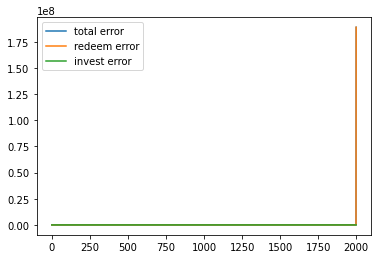

In [29]:
plt.figure()
plt.plot(switch_error, label='total error')
plt.plot(error_1, label='redeem error')
plt.plot(error_2, label='invest error')
plt.legend(loc='best');

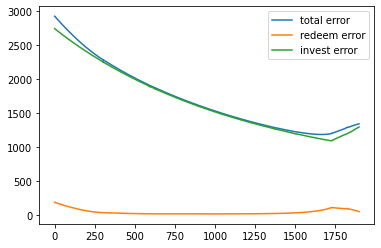

In [40]:
plt.figure()
plt.plot(switch_error[:-100], label='total error')
plt.plot(error_1[:-100], label='redeem error')
plt.plot(error_2[:-100], label='invest error')
plt.legend(loc='best')

In [31]:
#@title
import copy
t2 = copy.deepcopy(tcsComp)
t1 = t2.copy()

tmp_pf = fund - redemptAmt
for ind, val in enumerate(t1):
  val.value = tmp_pf[ind]
  # val.weight = (tmp_pf/np.sum(tmp_pf))[ind]

In [32]:
#@title
dist2, cw2, mw2, rw2, redemptAmt2, fund2, status2  = redempt(t1, 560, simple=True)
df = pd.DataFrame([dist2, cw2, fund2, mw2, rw2, redemptAmt2])
df.columns = [i.ticker for i in t1]
df.index = ['redeemed weight', 'original weight', 'original fund', 'model weight', 'final weight', 'redemption amt']
df.round(5)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 16.80087320004755
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 4
0.44800000182091065


,VTI,DGRO,IWP,VWO,IVW,EFAV,AGG,MUB,PNQI,CASH
redeemed weight,0.00000,0.00000,0.00000,0.00000,0.38412,0.00000,0.00000,0.00000,0.06388,0.00000
original weight,0.02105,0.31184,0.00140,0.04643,0.45166,0.17267,0.25881,0.04410,0.13142,0.00862
original fund,26.31281,389.79436,1.74754,58.04199,564.58087,215.83641,323.50771,55.12863,164.27526,10.77443
model weight,0.26000,0.22000,0.03000,0.03000,0.02000,0.10000,0.11000,0.19000,0.02000,0.02000
final weight,0.02105,0.31184,0.00140,0.04643,0.06754,0.17267,0.25881,0.04410,0.06754,0.00862
redemption amt,0.00000,0.00000,0.00000,0.00000,480.15280,0.00000,0.00000,0.00000,79.84720,0.00000


In [33]:
fund = [i.value for i in tcsComp3]
iter = int(np.ceil(np.sum(fund)))
lb = [np.max([i.minRedemptionAmt, i.marketprice * i.minRedemptionUnits]) for i in tcsComp]
redeem_error = np.zeros(iter)
invest_error = np.zeros(iter*2)

In [34]:
for i in range(0, iter):
  dist_redeem, cw_redeem, mw, rw, redemptAmt, fund, status_redeem  = redempt(tcsComp3, i, disp=False)
  redeem_error[i] = relative_loss(mw, rw)
  if not math.isclose(i, np.sum(redemptAmt), abs_tol=1e0):
    if status_redeem == False:
      print('REDEMPTION ERROR: Input demand ', i, ';   Output amout', np.sum(redemptAmt))

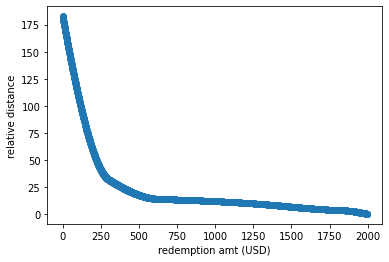

In [35]:
# plt.figure(figsize=(8,3))
plt.scatter(np.arange(0, iter-5), redeem_error[0:-5])
plt.xlabel('redemption amt (USD)')
plt.ylabel('relative distance');

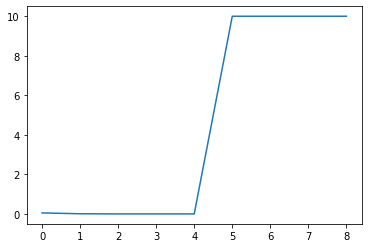

In [36]:
plt.plot(redeem_error[-10:-1])

In [ ]:
invest_iters = iter * 2
invest_error = np.zeros(invest_iters)
for i in range(0, invest_iters):
  dist_invest, cw_invest, mw, iw, investAmt, fund, status_invest  = investOptim(tcsComp3, i, disp=False)
  invest_error[i] = relative_loss(mw, iw)
  if not math.isclose(i, np.sum(investAmt), abs_tol=1e0):
    if status_invest == False:
      print('INVESTMENT ERROR: Input demand ', i, ';   Output amout', np.sum(investAmt))

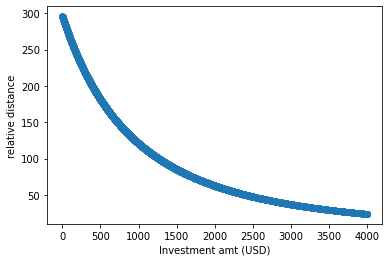

In [ ]:
#@title
# plt.figure(figsize=(8,3))
plt.scatter(np.arange(0, invest_iters), invest_error)
plt.xlabel('Investment amt (USD)')
plt.ylabel('relative distance');

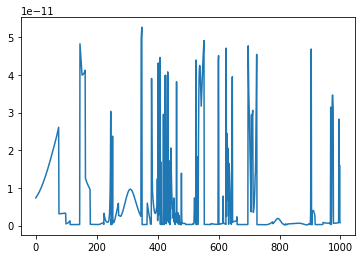

In [ ]:
plt.plot(invest_error[1000:2000])

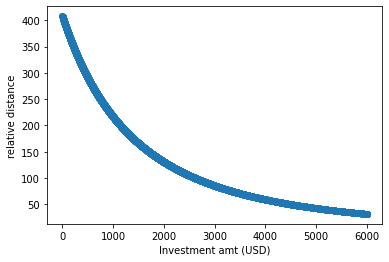

In [ ]:
#@title
# plt.figure(figsize=(8,3))
plt.scatter(np.arange(0, invest_iters), invest_error)
plt.xlabel('Investment amt (USD)')
plt.ylabel('relative distance');

In [ ]:
#@title
fund = [i.value for i in tcsComp]
iter = int(np.ceil(np.sum(fund)))
lb = [np.max([i.minRedemptionAmt, i.marketprice * i.minRedemptionUnits]) for i in tcsComp]
redeem_error_decompose = np.zeros(iter)
amt_set = set()
# [print(i.minRedemptionAmt) for i in tcsComp]

for i in range(0, iter):
  amt_set.add(i)
  dist, cw, mw, rw, redemptAmt, fund, status  = redempt(tcsComp, i, disp=False)
  redeem_error_decompose[i] = relative_loss(mw, rw)
  if not math.isclose(i, np.sum(redemptAmt), abs_tol=1e-2):
    amt_set.remove(i)
    if status == False:
      print('REDEMPTION ERROR: Input demand ', i, ';   Output amout', np.sum(redemptAmt))
      amt1, amt2 = decompose(amt_set, i, thres=5)
      # print(amt1, amt2)

      dist, cw, mw1, rw1, redemptAmt1, fund, status  = redempt(tcsComp, amt2, disp=False) 
      tmp_pf = fund - redemptAmt1 # portfolio after 1st redemptioin

      t1 = copy.deepcopy(tcsComp)
      for ind, val in enumerate(t1):
        # update new pf on a copy of original pf
        val.value = tmp_pf[ind]

      # 2nd redemption on new pf t1
      dist, cw, mw2, rw2, redemptAmt2, fund, status  = redempt(t1, amt1, disp=False, simple=True)

      # portforlio after two redemption
      redeem_total = (redemptAmt1 + redemptAmt2)
      pf = fund - redeem_total
      # check if the result breaks teh
      if ((np.ones_like(lb) * 1e-5 < redeem_total) & ( redeem_total < lb)).any(): 
          print('Exception: break minRedemptionAmt constraints', redeem_total)

      rw_new = pf/np.sum(pf)
      tmp = relative_loss(mw, rw_new)
      print('The decreased value is ', redeem_error_decompose[i] - tmp)
      redeem_error_decompose[i] = tmp


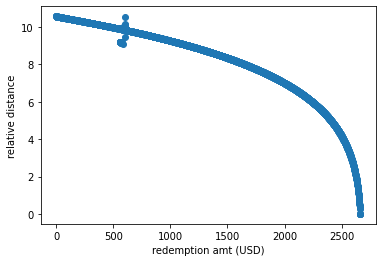

In [ ]:
# plt.figure(figsize=(8,3))
plt.scatter(np.arange(0, iter), redeem_error_decompose)
plt.xlabel('redemption amt (USD)')
plt.ylabel('relative distance');

In [ ]:
#@title
redeem_error_dist = np.zeros(iter)
amt_set = set()
# [print(i.minRedemptionAmt) for i in tcsComp]

for i in range(0, iter):
  amt_set.add(i)
  dist, cw, mw, rw, redemptAmt, fund, status  = redempt(tcsComp, i, disp=False)
  redeem_error_dist[i] = relative_loss(mw, rw)
  if not math.isclose(i, np.sum(redemptAmt), abs_tol=1e-2):
    amt_set.remove(i)
    if status == False:
      print('REDEMPTION ERROR: Input demand ', i, ';   Output amout', np.sum(redemptAmt))
      amt1 = max(amt_set)
      # print(amt1, amt2)
      dist, cw, mw1, rw1, redemptAmt1, fund, status  = redempt(tcsComp, amt1, disp=False)
      
      # distributing extra amout uniformly on tickers
      redeem_amt_final = (i-amt1)/len(fund) * np.ones_like(fund) + redemptAmt1

      # portforlio after two redemption
      pf = fund - redeem_amt_final
      rw_new = pf/np.sum(pf)
      tmp = relative_loss(mw, rw_new)
      print('the updated value is ', tmp - redeem_error_dist[i])
      redeem_error_dist[i] = tmp


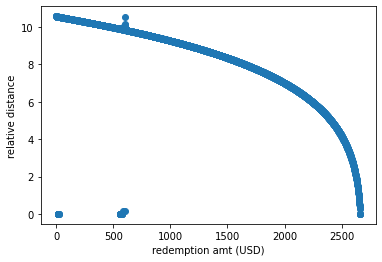

In [ ]:
# plt.figure(figsize=(8,3))
plt.scatter(np.arange(0, iter), redeem_error_dist)
plt.xlabel('redemption amt (USD)')
plt.ylabel('relative distance');

In [ ]:
#@title
def investBalance(tcsComp, orderAmt, thres, cash, lb=True):
  fund = np.asarray([float(i.value) for i in tcsComp]) #[spy, ivv, ...]
  fundTotal = fund.sum() + orderAmt # total funding after topup
  currWeight = fund / fundTotal # fund = [spy, ivv]
  modelWeight = np.asarray([float(i.weight) for i in tcsComp])

  deltaWeight = orderAmt / fundTotal # scalar

  bnds_0 = [(0, None) for i in tcsComp]
  bnds = [(0, None) for i in tcsComp]
  rebalance = False
  if lb:
    bnds = [(np.max([i.minRedemptionAmt, i.marketprice * i.minRedemptionUnits, i.minInitialInvestmentAmt * (i.value==0)]) 
    * (1+i.contributionFee) / fundTotal, None) for i in tcsComp]
  
  # x0 = np.ones(len(tcsComp)) * deltaWeight / len(tcsComp)  # initial weight
  x0 = np.array(a)/fundTotal
  
  cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - deltaWeight}) 

  print(deltaWeight)

  result = minimize(obj, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-20})

  investedWeight = (result.x*fundTotal+ fund) / fundTotal

  if np.any(investedWeight < modelWeight * (1-thres)) or np.any(investedWeight > modelWeight * (1+thres)):
    ind = [ind for ind, val in enumerate(modelWeight==0) if val==True]
    if (len(ind)==1 and tcsComp[ind].tickers == 'Cash' and investedWeight[ind] < cash):
      return result.x, currWeight, modelWeight, (result.x*fundTotal+ fund) / fundTotal, result.x * fundTotal

      # rebalance
    else:
      rebalance = True
      investAmt = fundTotal * modelWeight
      return rebalance, currWeight, modelWeight, investAmt/investAmt.sum(), investAmt

  else:
      return result.x, currWeight, modelWeight, (result.x*fundTotal+ fund) / fundTotal, result.x * fundTotal

def obj(d_cw, currWeight, modelWeight, bnds, deltaWeight):
    np.set_printoptions(precision=3)
    res = []
    i=0
    for ind, val in enumerate(d_cw):
      i+=1
      if val < bnds[ind][0]/2:         
        d_cw[ind] = 0

      elif val > bnds[ind][0]/2 and val < bnds[ind][0]:
        d_cw[ind] = bnds[ind][0]

      # cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - deltaWeight}) # x >= b; b in {0,1} x=0.5

      # result = minimize(obj1, d_cw, args=(currWeight, modelWeight, bnds), method='SLSQP', constraints=cons, bounds=bnds, options={'ftol':1e-20})
      # res.append(result.x)
      # d_cw = result.x    
    return np.linalg.norm((currWeight+d_cw-modelWeight))**2 

def obj1(d_cw, currWeight, modelWeight, bnds):
  return np.linalg.norm((currWeight+d_cw-modelWeight))**2

In [ ]:
#@title
def investBalanceNormal(tcsComp, orderAmt, thres, cash, lb=True):
  fund = np.asarray([float(i.value) for i in tcsComp]) #[spy, ivv, ...]
  fundTotal = fund.sum() + orderAmt # total funding after topup
  currWeight = fund / fundTotal # fund = [spy, ivv]
  modelWeight = np.asarray([float(i.weight)+np.finfo(np.double).tiny for i in tcsComp])

  deltaWeight = orderAmt / fundTotal # scalar

  bnds_0 = [(0, None) for i in tcsComp]
  bnds = [(0, None) for i in tcsComp]
  rebalance = False
  if lb:
    bnds = [(np.max([i.minTopupAmt, i.marketprice * i.minTopupUnits, i.minInitialInvestmentAmt * (i.value==0)]) 
    * (1+i.contributionFee) / fundTotal, None) for i in tcsComp]
  
  # x0 = np.ones(len(tcsComp)) * deltaWeight / len(tcsComp)  # initial weight
  x0 = np.array(a)/fundTotal
  
  cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - deltaWeight}) 

  print(deltaWeight)

  result = minimize(obj, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-20})

  investedWeight = (result.x*fundTotal+ fund) / fundTotal

  if np.any(result.x+currWeight/modelWeight < (1-thres)) or np.any(result.x+currWeight/modelWeight  > (1+thres)):
    ind = [ind for ind, val in enumerate(modelWeight==0) if val==True]
    print(ind, len(ind))
    if (len(ind)==1 and tcsComp[ind[0]].ticker == 'Cash' and result.x+currWeight/modelWeight < cash):
      return result.x, currWeight, modelWeight, (result.x*fundTotal+ fund) / fundTotal, result.x * fundTotal

      # rebalance
    else:
      rebalance = True
      investAmt = fundTotal * modelWeight
      print(fundTotal, investAmt)
      return rebalance, currWeight, modelWeight, investAmt/investAmt.sum(), investAmt-fund

  else:
      return result.x, currWeight, modelWeight, (result.x*fundTotal+ fund) / fundTotal, result.x * fundTotal

def obj(d_cw, currWeight, modelWeight, bnds, deltaWeight):
    np.set_printoptions(precision=3)
    res = []
    i=0
    for ind, val in enumerate(d_cw):
      i+=1
      if val < bnds[ind][0]/2:         
        d_cw[ind] = 0

      elif val > bnds[ind][0]/2 and val < bnds[ind][0]:
        d_cw[ind] = bnds[ind][0]

      # cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - deltaWeight}) # x >= b; b in {0,1} x=0.5

      # result = minimize(obj1, d_cw, args=(currWeight, modelWeight, bnds), method='SLSQP', constraints=cons, bounds=bnds, options={'ftol':1e-20})
      # res.append(result.x)
      # d_cw = result.x    
    return np.linalg.norm((currWeight+d_cw-modelWeight)/modelWeight)**2 

def obj1(d_cw, currWeight, modelWeight, bnds):
  return np.linalg.norm((currWeight+d_cw-modelWeight))**2

In [ ]:
#@title
thres = np.random.rand(len(tcsComp))/4  # random threshold
# thres = np.zeros(len(tcsComp))+0.5; 
thres

In [ ]:
#@title
dist, cw, mw, iw, investAmt  = investBalanceNormal(tcsComp, orderAmt, thres, 0.02)
if type(dist)==bool:
  df = pd.DataFrame([mw * (1-thres), cw, mw * (1+thres), mw, iw, investAmt])
  df.columns = [i.ticker for i in tcsComp]
  df.index = ['lower bound', 'original weight', 'upper bound', 'model weight', 'invested weight', 'topup amt']
  df.loc['threshold'] = thres
  # df.loc['lower bound'] = mw * (1-thres)
  # df.loc['upper bound'] = mw * (1+thres)
  print("Rebalanced")
else:
  df = pd.DataFrame([dist, cw, mw, iw, investAmt])
  df.columns = [i.ticker for i in tcsComp]
  df.index = ['invest weight', 'original weight', 'model weight', 'invested weight', 'topup amt']
  df.loc['threshold'] = thres
  df

df